<a href="https://colab.research.google.com/github/RMoulla/Machine-learning/blob/main/TP_GNN_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Réseaux de neurones graphiques à base d'Attention.

Dans ce TP, nous nous proposons d'étudier le dataset Cora. Celui-ci est composé de 2708 papiers scientifiques répartis en sept classes. L'objectif de ce TP est de construire un modèle permettant de prédire la classe à laquelle appartient un noeud (papier scientifique).



In [ ]:
import os
import torch
import networkx as nx
import pandas as pd
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 32.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
import torch.nn.functional as F
import torch.nn as nn


import matplotlib.pyplot as plt

## Analyse du dataset Cora

On se propose ici d'explorer le dataset Cora. Il est fortement recommandé de compléter cette analyse exploratoire (visualiser le graphe, etc.).

In [ ]:
dataset = Planetoid(root='~/somewhere/Cora', name='Cora')

data = dataset[0]

Processing...
Done!


In [ ]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


Conformément à la sortie précédente : le dataset Cora est constitué d'un seul graphe. Il y a un total de 2708 nœuds dans le graphe. Chaque nœud du graphe a 1433 caractéristiques (ou attributs) associées. Ces caractéristiques permettent de classer chaque nœud en 7 catégories possibles. Le graphe a 10556 arêtes, ce qui représente les connexions entre les paires de nœuds. Ce qui donne une moyenne de connexion de 3.90 par nœud. Autrement, chaque nœud est relié en moyenne à 3.90 autres nœuds. Sur les 2708 nœuds, seuls 140 sont utilisés comme nœuds d'entraînement pour l'apprentissage du modèle. Et seulement 5% des nœuds du graphe ont des étiquettes (ou catégories) connues et sont utilisés pour l'entraînement. Il n'y a pas de nœuds isolés dans le graphe, ce qui signifie que chaque nœud est connecté à au moins un autre nœud. Il n'y a pas non plus d'auto-boucles dans le graphe, ce qui signifie qu'aucun nœud n'est directement connecté à lui-même.



In [ ]:
# Afficher les caractéristiques du premier nœud
first_node_features = data.x[0]
print("Caractéristiques du premier nœud :", first_node_features)


Caractéristiques du premier nœud : tensor([0., 0., 0.,  ..., 0., 0., 0.])


Dans le contexte du dataset Cora, les caractéristiques (features) d'un nœud sont représentées sous forme d'un vecteur de nombres réels. Chaque élément de ce vecteur correspond à une caractéristique spécifique du nœud. Les caractéristiques représentent un vecteur binaire indiquant la présence ou l'absence d'un mot spécifique du vocabulaire dans le document associé au nœud. Ces caractéristiques ne sont pas accompagnées d'un libellé explicite des noms des mots.

In [ ]:
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


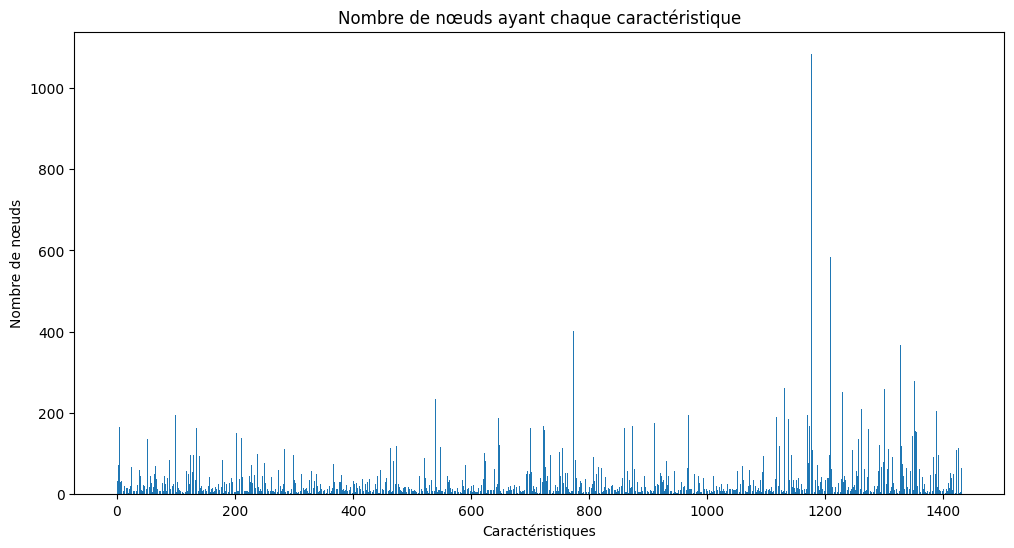

In [ ]:
# Calculer le nombre de nœuds ayant chaque caractéristique
feature_counts = torch.sum(data.x, dim=0)

# Créer un histogramme
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_counts)), feature_counts.numpy())
plt.title("Nombre de nœuds ayant chaque caractéristique")
plt.xlabel("Caractéristiques")
plt.ylabel("Nombre de nœuds")
plt.show()


Cet histogramme montre le nombre de document comportant chaque caractéristiques. Il permet de réaliser la grande présence d'une caractéristique, environs la 1190è dans plusieurs documents(+1000). A part cette drenière, seules 2 caractéristiques apparaissent plus de 400 fois. Quant au reste, chacune apparait moins de 200 fois.

In [ ]:
# Calculer le nombre de fois où chaque label apparaît
label_counts = torch.bincount(data.y)

# Calculer la moyenne et l'écart type des apparitions de chaque label
mean_appearances = torch.mean(label_counts.float())
std_appearances = torch.std(label_counts.float())

# Afficher les résultats
print("Nombre d'apparitions de chaque label :", label_counts)
print("Moyenne d'apparitions des labels :", mean_appearances.item())
print("Écart type d'apparitions des labels :", std_appearances.item())


Nombre d'apparitions de chaque label : tensor([351, 217, 418, 818, 426, 298, 180])
Moyenne d'apparitions des labels : 386.8571472167969
Écart type d'apparitions des labels : 211.82101440429688


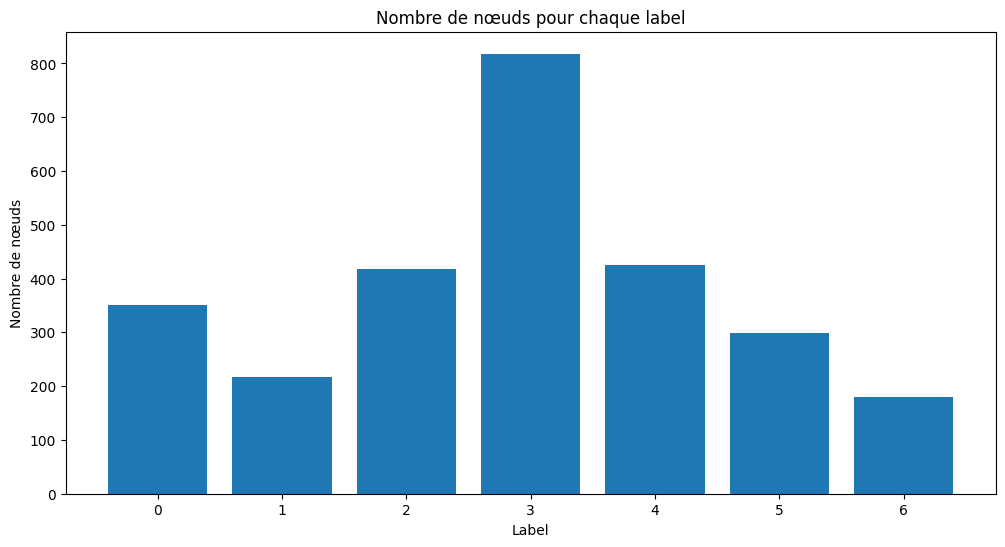

In [ ]:
# Calculer le nombre de nœuds pour chaque label
label_counts = torch.bincount(data.y)

# Créer un histogramme
plt.figure(figsize=(12, 6))
plt.bar(range(len(label_counts)), label_counts.numpy())
plt.title("Nombre de nœuds pour chaque label")
plt.xlabel("Label")
plt.ylabel("Nombre de nœuds")
plt.show()

La distribution des labels dans le dataset Cora n'est pas uniforme, avec des variations significatives dans le nombre d'apparitions de chaque label. Le label 3 notamment apparait significativement plus de fois que les autres avec 818 apparition. La moyenne (387) et l'écart type (211) fournissent des informations supplémentaires sur la tendance centrale et la dispersion de cette distribution. Ces statistiques peuvent être utiles pour comprendre la diversité et l'équilibre du dataset, ce qui peut avoir des implications pour l'entraînement d'un modèle de prédiction de la classe de chaque document comme cela se fera plus bas.

Tentons à présent d'afficher le graphe. Nous le ferons sans les noeuds pour question de visualisation.

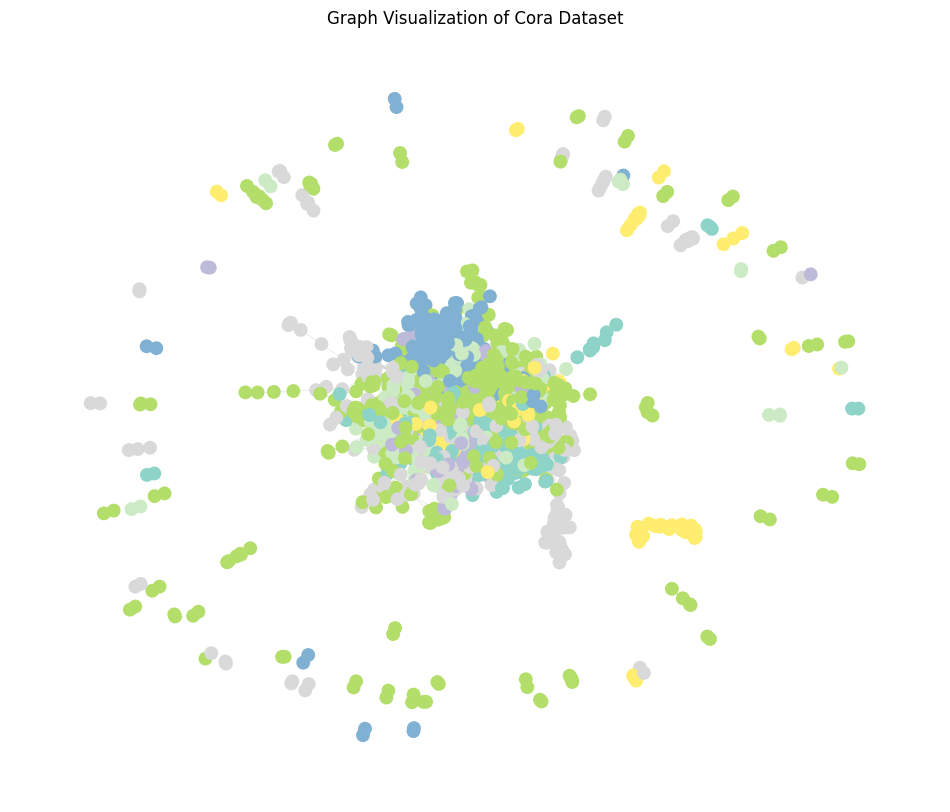

In [ ]:
# Convertir les données en un graphe NetworkX
graph = to_networkx(data, to_undirected=True)

# Visualiser le graphe
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(graph, seed=42)  # Layout pour la visualisation
nx.draw_networkx_nodes(graph, pos, node_size=80, node_color=data.y, cmap="Set3")
nx.draw_networkx_edges(graph, pos, width=0.1, alpha=0.5)
plt.title('Graph Visualization of Cora Dataset')
plt.axis('off')  # Désactiver les axes
plt.show()

On note une visualisation confuse avec une garnde concentration des noeuds au centre de la figure et une dispersion d'autres formant un cercle autour des noeuds du centre. Pour une meilleures visualisation, nous effectuerons plutot une ACP pour décomposer et mieux représenter les noeuds.

In [ ]:
# Effectuer l'Analyse en Composantes Principales (ACP)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

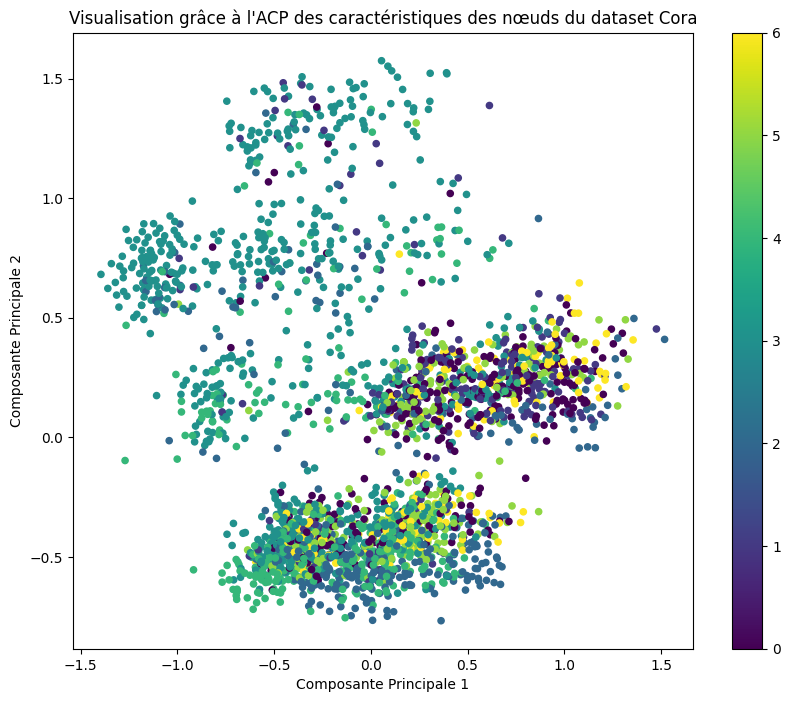

In [ ]:
# Tracer les variables initiales sur le plan des composantes principales
components = pca.fit_transform(data.x.numpy())

plt.figure(figsize=(10, 8))
plt.scatter(components[:, 0], components[:, 1], c=data.y, cmap='viridis', s=20)
plt.title("Visualisation grâce à l'ACP des caractéristiques des nœuds du dataset Cora")
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.colorbar()
plt.show()

Distribution des nœuds dans l'espace des composantes principales :

L'emplacement des points sur le graphique reflète la distribution des nœuds dans l'espace des deux premières composantes principales. Les nœuds similaires en termes de caractéristiques sont regroupés dans des zones similaires du graphique.

La dispersion des couleurs sur le graphique indique la variabilité des labels des nœuds dans l'espace des composantes principales. Des groupes de nœuds de la même couleur sont souvent associés à des zones distinctes, tandis que la dispersion peut indiquer une certaine variabilité dans la répartition des labels.

Le label zéro par exemple est essentiellement concentré dans la zone précise formant une agglutination des points autour de (0.25, 0.25). Un autre cercle difforme autour de (0.0, -0.5) contient un bon nombre des points de ce label.  

# Analyse prédictive

## Mise en place d'un modèle MLP

En théorie, nous devrions être en mesure de déduire la catégorie d'un document uniquement sur la base de son contenu, c'est-à-dire de sa représentation des caractéristiques du sac de mots, sans tenir compte d'aucune information relationnelle.

Vérifions cela en construisant un **MLP** simple qui opère uniquement sur les caractéristiques des nœuds d'entrée (en utilisant des poids partagés entre tous les nœuds) :

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Notre MLP est défini par deux couches linéaires et amélioré par la non-linéarité et l'abandon de ReLU. Ici, nous réduisons d'abord le vecteur de caractéristiques à 1433 dimensions à un encastrement à faible dimension (hidden_channels=16), tandis que la deuxième couche linéaire agit comme un classificateur qui doit faire correspondre chaque encastrement de nœud à faible dimension à l'une des 7 classes.

Nous utilisons la perte d'entropie croisée et l'optimiseur d'Adam. Nous définissons également une fonction de test pour évaluer les performances de notre modèle final sur l'ensemble de nœuds de test (dont les étiquettes n'ont pas été observées pendant la formation).

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9620
Epoch: 002, Loss: 1.9028
Epoch: 003, Loss: 1.8414
Epoch: 004, Loss: 1.7562
Epoch: 005, Loss: 1.6390
Epoch: 006, Loss: 1.5614
Epoch: 007, Loss: 1.4282
Epoch: 008, Loss: 1.3505
Epoch: 009, Loss: 1.2642
Epoch: 010, Loss: 1.1786
Epoch: 011, Loss: 1.0887
Epoch: 012, Loss: 0.9625
Epoch: 013, Loss: 0.9238
Epoch: 014, Loss: 0.8177
Epoch: 015, Loss: 0.7710
Epoch: 016, Loss: 0.6766
Epoch: 017, Loss: 0.6483
Epoch: 018, Loss: 0.5992
Epoch: 019, Loss: 0.5322
Epoch: 020, Loss: 0.5321
Epoch: 021, Loss: 0.4861
Epoch: 022, Loss: 0.5026
Epoch: 023, Loss: 0.4680
Epoch: 024, Loss: 0.4276
Epoch: 025, Loss: 0.3171
Epoch: 026, Loss: 0.3861
Epoch: 027, Loss: 0.3429
Epoch: 028, Loss: 0.3349
Epoch: 029, Loss: 0.3290
Epoch: 030, Loss: 0.3381
Epoch: 031, Loss: 0.3494
Epoch: 032, Loss: 0.2594
Epoch: 033, Loss: 0.3263
Epoch: 034, Loss: 0.2667
Epoch: 035, Loss: 0.3240
Epoch: 036, Loss: 0.3576
Epoch: 037, Loss: 0.3447
Epoch: 038, Loss: 0.2687
Epoch: 039, Loss: 0.2610
Epoch: 040, Loss: 0.2472


Après avoir entraîné le modèle, nous pouvons appeler la fonction de test pour connaître les performances de notre modèle sur des étiquettes inédites. Nous nous intéressons ici à la précision du modèle.

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5830


Comme on peut le constater, notre MLP obtient des résultats plutôt médiocres, avec une précision d'environ 58.30 % seulement. La principale raison en est probablement un surajustement important, car il n'a accès qu'à un petit nombre de nœuds d'apprentissage et se généralise donc mal aux représentations des nœuds non vus.

Il ne parvient pas non plus à intégrer un biais important dans le modèle. Nous utiliserons donc des réseaux neuronaux graphiques pour améliorer les performances de notre modèle.

## Construction d'un modèle à base de GAT qui permet de prédire la classe à laquelle appartient un noeud.



Nous remplaçons simplement les couches linéaires par des couches GAT, pour atteindre une meilleure précision.

In [ ]:
from torch_geometric.transforms import NormalizeFeatures

dataset.transform = T.NormalizeFeatures()

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1


        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
#dataset.transform = T.NormalizeFeatures()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model = GAT().to(device)
data = dataset[0].to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1500):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    if epoch%200 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

tensor(1.9476, grad_fn=<NllLossBackward0>)
tensor(0.8077, grad_fn=<NllLossBackward0>)
tensor(0.5096, grad_fn=<NllLossBackward0>)
tensor(0.6007, grad_fn=<NllLossBackward0>)
tensor(0.5898, grad_fn=<NllLossBackward0>)
tensor(0.5183, grad_fn=<NllLossBackward0>)
tensor(0.5434, grad_fn=<NllLossBackward0>)
tensor(0.5925, grad_fn=<NllLossBackward0>)


In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8290


de test de **82,90 %** !
Cela contraste fortement avec les 58,30% de précision obtenus par notre MLP, ce qui indique que les informations relationnelles jouent un rôle crucial dans l'obtention de meilleures performances.

Nous pouvons également le vérifier une fois de plus en examinant les encastrements de sortie de notre modèle **entraîné**, qui produit maintenant un bien meilleur regroupement des nœuds de la même catégorie.

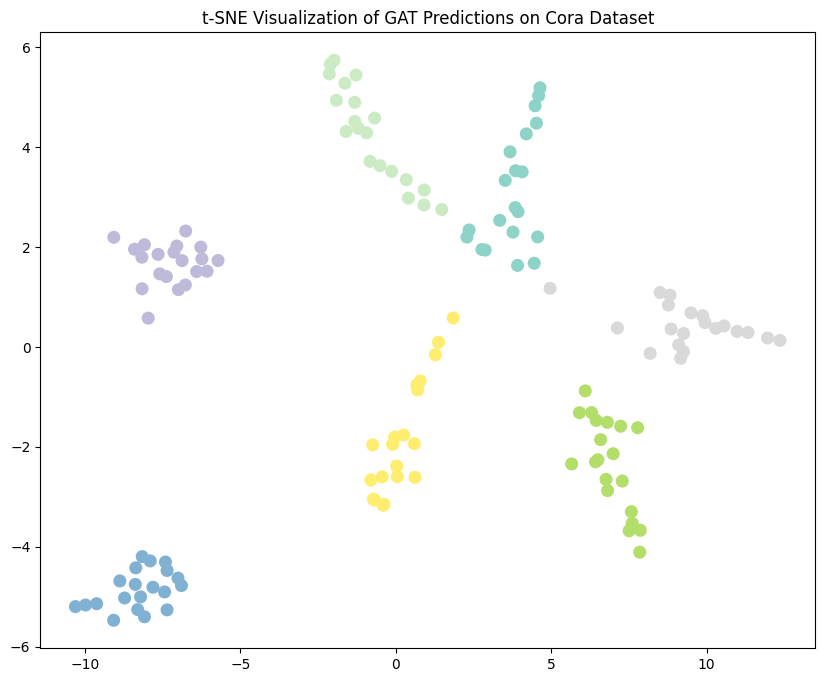

In [ ]:
from sklearn.manifold import TSNE

# Evaluate the GAT model on the test set
model.eval()
with torch.no_grad():
    out = model(data)

# Visualize the results with t-SNE
tsne = TSNE(n_components=2)
embedding = tsne.fit_transform(out[data.train_mask].cpu().numpy())

# Visualize the results of the prediction
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=data.y[data.train_mask].cpu(), cmap="Set3", s=70)
plt.title('t-SNE Visualization of GAT Predictions on Cora Dataset')
plt.show()


Les encastrements sur les données du 'train' permettent déjà de visualiser un meilleur regroupement et la formation de cluster bien différentiés dans l'espace bidimentionnel obtenu avec le t-SNE. Les points de même couleur sont en effet regroupés ensemble. Ce qui caractérise la similarité entre ces derniers.

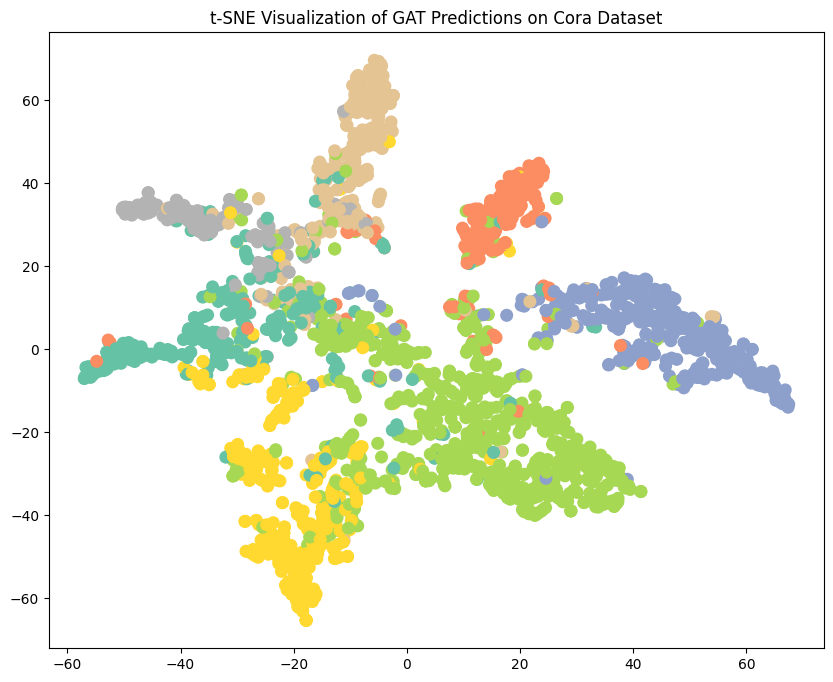

In [ ]:
# Visualize the results of the prediction
plt.figure(figsize=(10, 8))
embedding = tsne.fit_transform(out[:data.num_nodes].cpu().numpy())

plt.scatter(embedding[:, 0], embedding[:, 1], c=data.y[:data.num_nodes].cpu(), cmap="Set2", s=70)

plt.title('t-SNE Visualization of GAT Predictions on Cora Dataset')
plt.show()

Ce code génère une visualisation t-SNE des résultats du modèle GAT sur tout le dataset Cora. Chaque point dans le nuage de points représente une instance de données, positionnée dans un espace bidimensionnel de manière à refléter les relations de similarité entre les instances. Les couleurs des points indiquent les étiquettes réelles des données. Cette visualisation permet d'observer la structure des prédictions du modèle dans un espace réduit. Il permet aussi et surtout de se rendre compte de la précision bonne du modèle GAT dans la tâche de classification des noeuds. Et de sa capacité à capturer des relations significatives dans un espace de dimension réduit.

En conclusion, le modèle GAT (Graph Attention Network) est une architecture de réseau neuronal conçue pour la tâche de classification sur des données de graphe. Contrairement aux réseaux convolutifs traditionnels, le GAT est capable de prendre en compte les relations non seulement dans le voisinage spatial, mais également de manière attentionnelle, en assignant des poids différents aux voisins en fonction de leur importance. Lui permettant ainsi de modéliser les relations complexes entre les nœuds. Son utilisation est donc bénéfique dans des domaines où les données sont naturellement représentées sous forme de graphe, comme dans les réseaux sociaux, la biologie des systèmes, et d'autres applications similaires. Cependant, comme pour tout modèle, il est important de l'adapter correctement aux spécificités de la tâche et des données pour obtenir des performances optimales. Dans notre étude de cas, il permet un gain de performance d'environ 40% sur les méthodes classiques. Et même si la précison finale d'environ 83% est bonne, il importe par d'autres méthodes de l'améliorer comme par exemple par une optimisation de ses paramètres.





